# Data augmentation
- artificiellt skapa fler bilder
- slumpmässigt:
    - roterar till en viss grad (radianer)
    - translatera slumpmässigt
    - flippa horisontellt, vertikalt (spegla)
    - shear
    - ...

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import  load_data

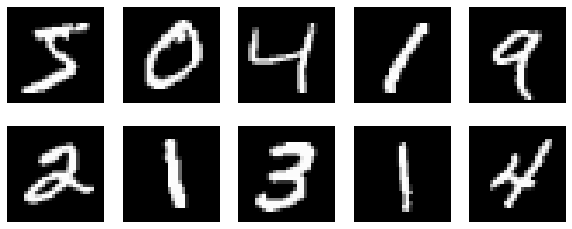

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize = (10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")

plot_samples(X_train)

In [3]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Train|val|test split

In [4]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=1/6, random_state=42)

X_train_val = X_train_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]
X_test = X_test[:,:,:,None]


X_train_val.shape

(50000, 28, 28, 1)

# Data augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_image_generator = ImageDataGenerator(
    rotation_range = 10,
    shear_range = .2,
    zoom_range = .1,
    horizontal_flip = False,
    height_shift_range = .2,
    width_shift_range = .2
)

# don't augment validation and test data
test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size = 32)
val_generator = test_image_generator.flow(X_val, y_val, batch_size = 32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x1dd1d045790>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x1dd16bf9640>)

2
(32, 28, 28, 1)


array([0, 2, 3, 2, 1, 7, 0, 8, 9, 2, 1, 8, 0, 7, 9, 4, 8, 5, 6, 8, 0, 6,
       5, 1, 9, 7, 2, 1, 0, 3, 4, 2], dtype=uint8)

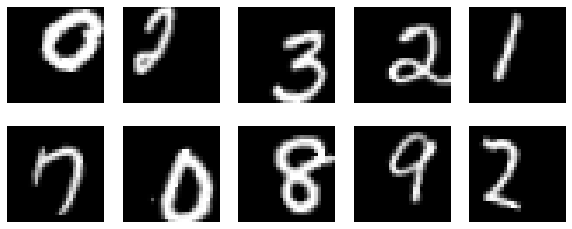

In [7]:
print(len(train_val_generator.next()))

sample_batch = train_val_generator.next()
print(sample_batch[0].shape) # 32 samples in a batch

plot_samples(sample_batch[0])
sample_batch[1]

### CNN model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [11]:
def CNN_model(learning_rate = .001, drop_rate = .5, kernels = [32, 32]):
    adam = Adam(learning_rate = learning_rate)
    
    model = Sequential(name = "CNN_model")
    
    # the convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_normal", input_shape = X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPool2D(pool_size = (2, 2), strides = 2))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu",  kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax")) # output layer, 1 node per label
    
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])
    
    return model

model = CNN_model(drop_rate = .5)
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 800)               0         
                                                                 
 dropout_2 (Dropout)         (None, 800)               0 

## Train on augmented data

In [17]:
steps_per_epoch = int(len(X_train_val) / 32)
validation_steps = int(len(X_val) / 32)

steps_per_epoch, validation_steps

(1562, 312)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = True) # loss = min, acc = max

model.fit(
    train_val_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    callbacks = [early_stopper],
    validation_data = val_generator,
    validation_steps = validation_steps
)

Epoch 1/100
1562/1562 [==============================] - 19s 7ms/step - loss: 0.6133 - acc: 0.8002 - val_loss: 0.1548 - val_acc: 0.9552
Epoch 2/100
1562/1562 [==============================] - 10s 6ms/step - loss: 0.2651 - acc: 0.9154 - val_loss: 0.0781 - val_acc: 0.9772
Epoch 3/100
1562/1562 [==============================] - 9s 6ms/step - loss: 0.2033 - acc: 0.9353 - val_loss: 0.0756 - val_acc: 0.9784
Epoch 4/100
1562/1562 [==============================] - 10s 6ms/step - loss: 0.1806 - acc: 0.9437 - val_loss: 0.0786 - val_acc: 0.9773
Epoch 5/100
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1600 - acc: 0.9502 - val_loss: 0.0638 - val_acc: 0.9808
Epoch 6/100
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1507 - acc: 0.9533 - val_loss: 0.0615 - val_acc: 0.9823
Epoch 7/100
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1403 - acc: 0.9566 - val_loss: 0.0420 - val_acc: 0.9865
Epoch 8/100
1562/1562 [=============================

In [19]:
metrics = pd.DataFrame(model.history.history)

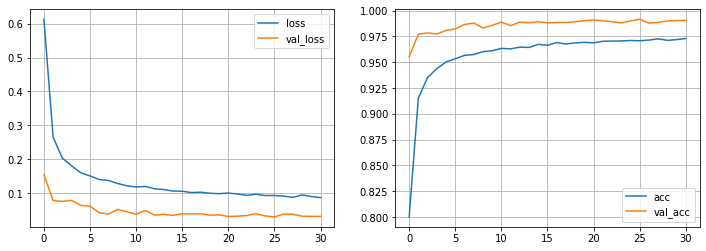

In [21]:
def plot_metrics(metrics):
     _, ax = plt.subplots(1, 2, figsize = (12, 4))
     metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
     metrics[["acc", "val_acc"]].plot(ax = ax[1], grid = True)
     
plot_metrics(metrics)

## Train on all training data

In [22]:
train_generator = train_image_generator.flow(X_train, y_train, batch_size = 32)

In [23]:
model = CNN_model()
model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = 15)

Epoch 1/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.6414 - acc: 0.7897
Epoch 2/15
1562/1562 [==============================] - 9s 6ms/step - loss: 0.2630 - acc: 0.9156
Epoch 3/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.2066 - acc: 0.9341
Epoch 4/15
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1773 - acc: 0.9443
Epoch 5/15
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1642 - acc: 0.9494
Epoch 6/15
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1480 - acc: 0.9529
Epoch 7/15
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1397 - acc: 0.9565
Epoch 8/15
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1301 - acc: 0.9591
Epoch 9/15
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1281 - acc: 0.9600
Epoch 10/15
1562/1562 [==============================] - 9s 6ms/step - loss: 0.1221 - acc: 0.9622
Epoch 11/15
1562/1562 [====

## Evaluation

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



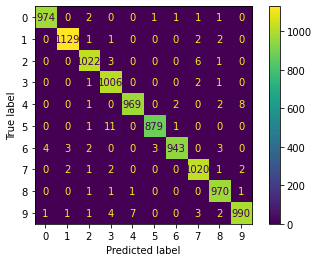

In [25]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()